In [69]:
import torch
import torch.nn as nn
from strokeForVision import StrokePatientsMIDataset
from torcheeg.transforms import Select,BandSignal,Compose
from to import ToGrid, ToTensor
from downsample import SetSamplingRate
from baseline import BaselineCorrection

dataset = StrokePatientsMIDataset(root_path='./subdataset',
                                #   io_path='.torcheeg/datasets_1743581752846_TAhGJ',
                        chunk_size=2000,  # 1 second
                        # overlap = 250,
                        offline_transform=Compose(
                                [BaselineCorrection(),
                                # SetSamplingRate(origin_sampling_rate=500,target_sampling_rate=128),
                                BandSignal(sampling_rate=500,band_dict={'frequency_range':[8,40]})
                                ]),
                        # online_transform=Compose(
                        #         [ToTensor()]),
                        label_transform=Select('label'),
                        num_worker=8
)
print(dataset[0][0].shape) #EEG shape:torch.Size([1, 128, 9, 9])
print(dataset[0][1])  # label (int)
print(len(dataset))

[2025-04-17 16:33:27] INFO (torcheeg/MainThread) 🔍 | Processing EEG data. Processed EEG data has been cached to .torcheeg/datasets_1744878807326_CtkTn.
[2025-04-17 16:33:27] INFO (torcheeg/MainThread) ⏳ | Monitoring the detailed processing of a record for debugging. The processing of other records will only be reported in percentage to keep it clean.
[PROCESS]: 100%|██████████| 1/1 [00:00<00:00, 1733.90it/s]

[RECORD ./subdataset/sourcedata/sub-01/sub-01_task-motor-imagery_eeg.mat]: 0it [00:00, ?it/s]
[RECORD ./subdataset/sourcedata/sub-01/sub-01_task-motor-imagery_eeg.mat]: 1it [00:00,  4.45it/s]
[RECORD ./subdataset/sourcedata/sub-01/sub-01_task-motor-imagery_eeg.mat]: 21it [00:00, 80.42it/s]
[RECORD ./subdataset/sourcedata/sub-01/sub-01_task-motor-imagery_eeg.mat]: 40it [00:00, 117.60it/s]
[RECORD ./subdataset/sourcedata/sub-01/sub-01_task-motor-imagery_eeg.mat]: 58it [00:00, 138.21it/s]
[RECORD ./subdataset/sourcedata/sub-01/sub-01_task-motor-imagery_eeg.mat]: 78it [00:00, 157.66it

(1, 30, 2000)
0
40


In [70]:
print(dataset[1][0].shape)
eeg_data = dataset[1][0].reshape(30,2000)
print(eeg_data.shape)
print(eeg_data[0][16])

(1, 30, 2000)
(30, 2000)
-2.6694351811838626


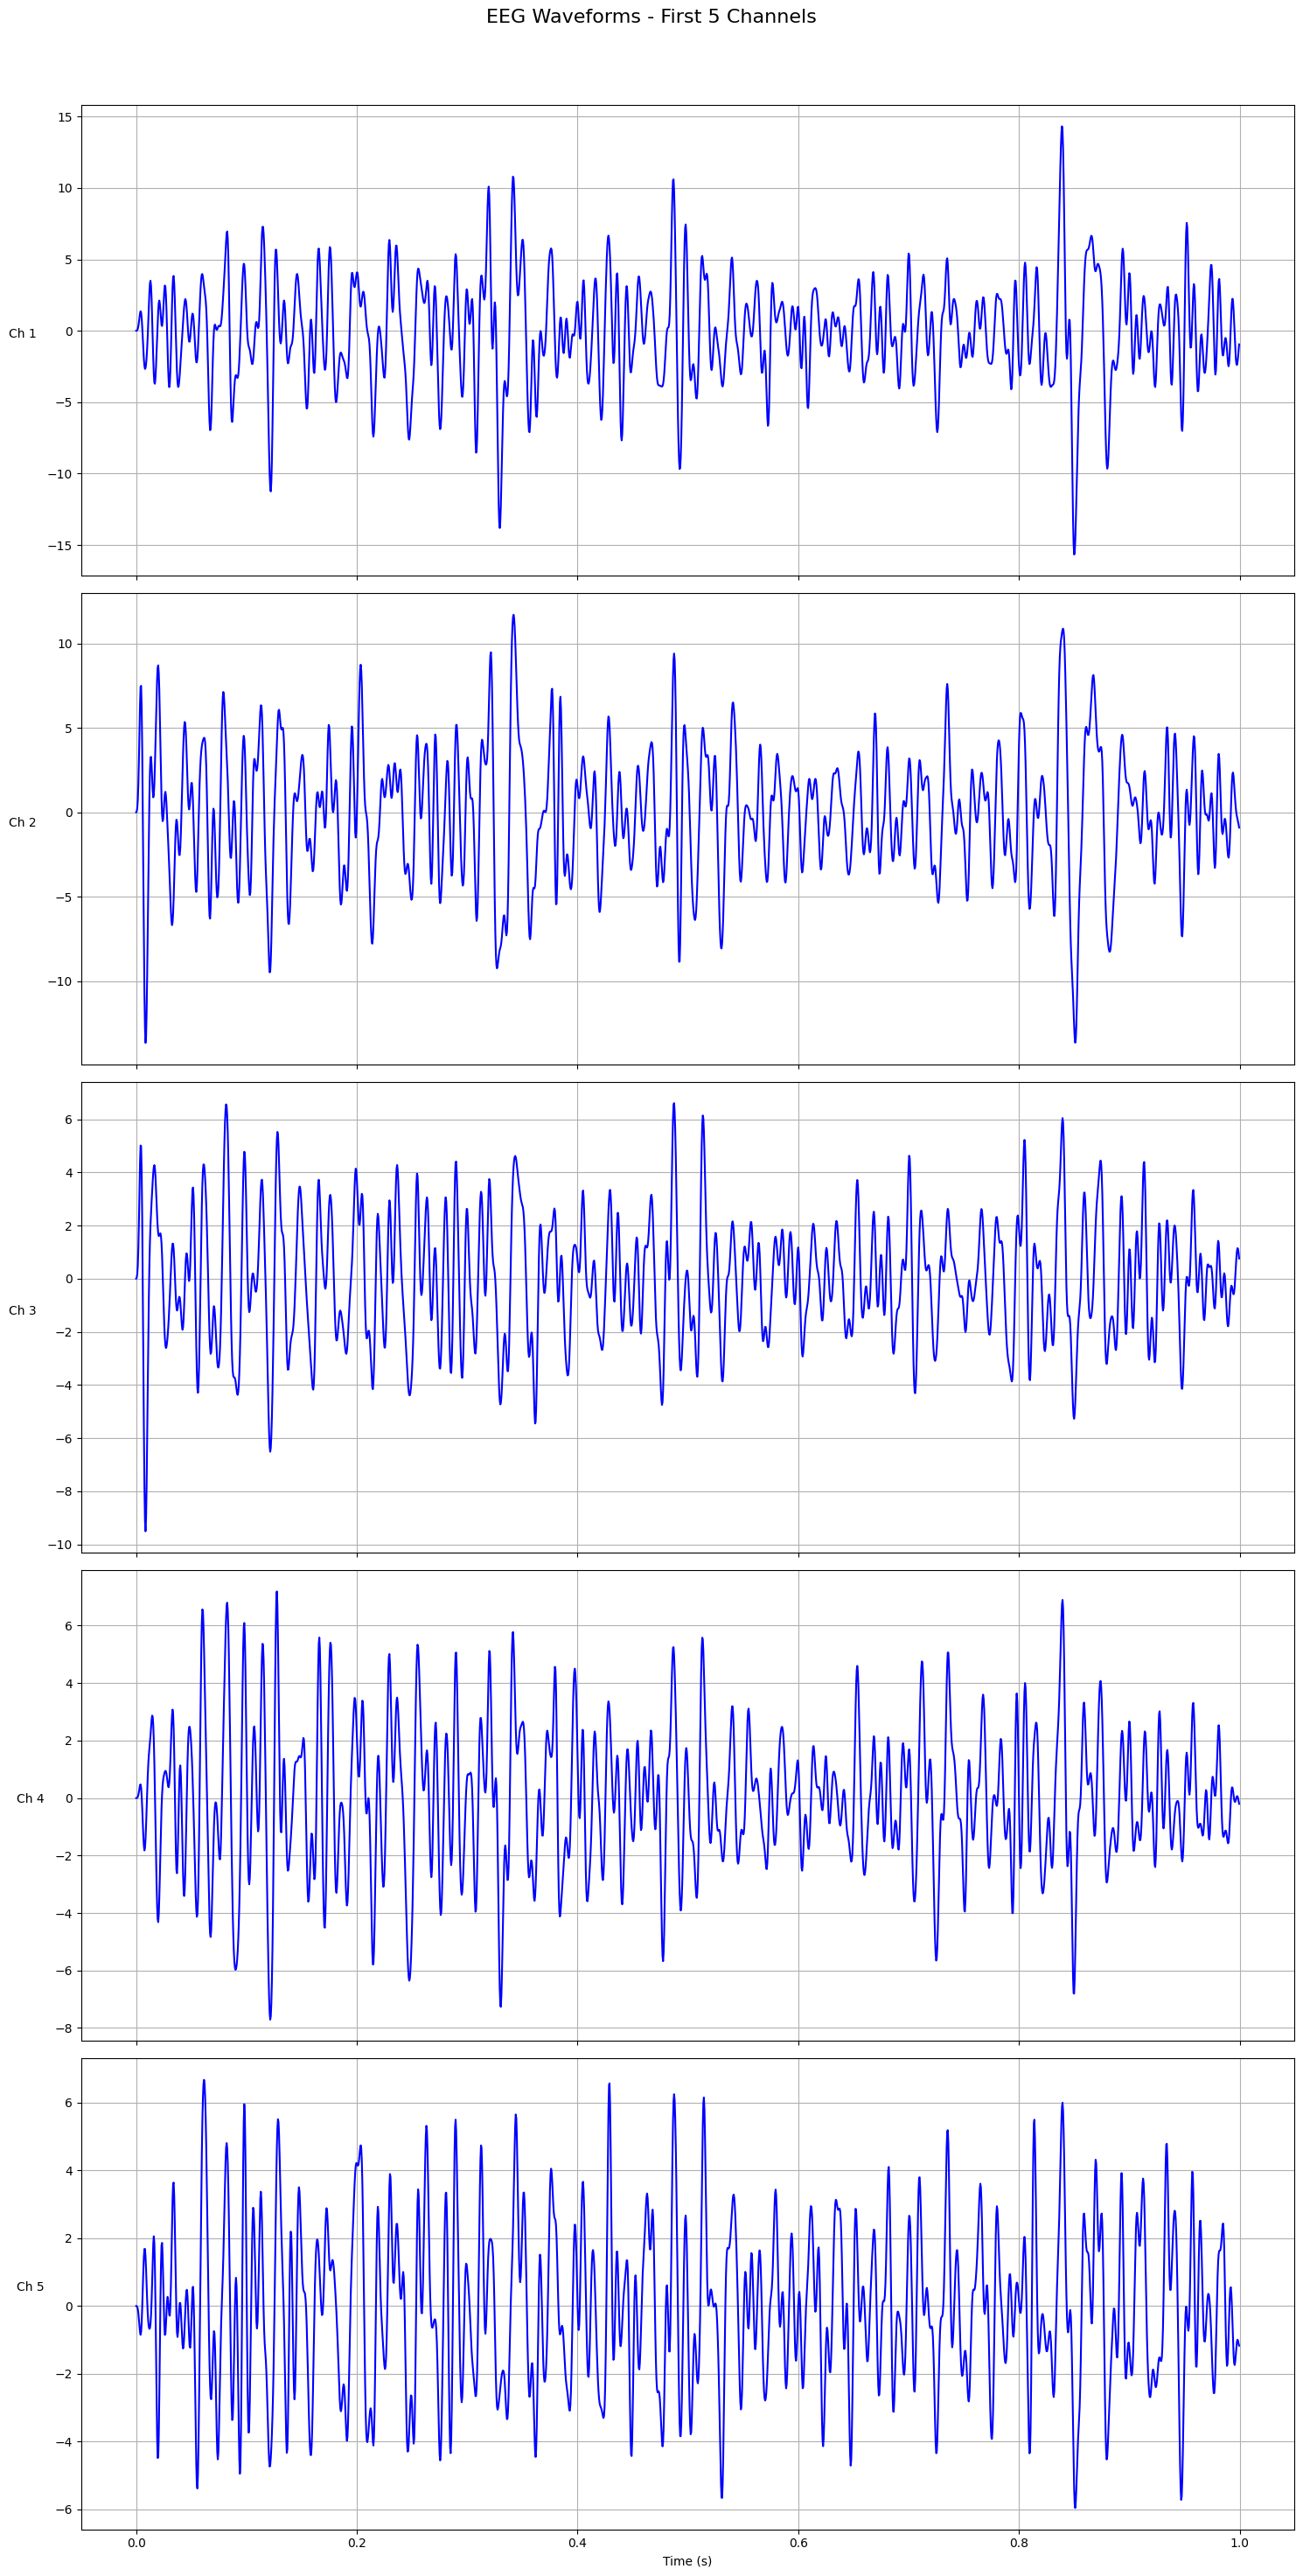

In [71]:
import numpy as np
import matplotlib.pyplot as plt

# 假设 eeg_data 是 shape 为 (30, 2000) 的 EEG 数据
# 你可以用实际数据替换这个模拟数据


# 时间轴（假设采样率为 250Hz，则 2000 点 ≈ 8 秒）
fs = 2000  # 采样率（可根据实际修改）
time = np.arange(2000) / fs  # 时间轴，单位：秒

# 只取前 5 个通道
num_channels = 5
fig, axs = plt.subplots(num_channels, 1, figsize=(15, 30), sharex=True)

for i in range(num_channels):
    axs[i].plot(time, eeg_data[i], color='b')
    axs[i].set_ylabel(f'Ch {i+1}', rotation=0, labelpad=20)
    axs[i].grid(True)

axs[-1].set_xlabel('Time (s)')
plt.suptitle('EEG Waveforms - First 5 Channels', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [48]:
import os
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import mne
import re

def bandpass_filter(data, fs, lowcut, highcut, order=2):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=1)

def plot_topomap(file, fs: int, lowcut: int, highcut: int, ch_names: list, save_path: str, fig_name: str):
    # 解析文件名，提取 subject_id
    subject_id = int(re.findall("sub-(\d\d)_task-motor-imagery_eeg.mat", file)[0])
    
    # 加载.mat文件数据
    mat_data = scipy.io.loadmat(file)
    X, Y = mat_data['eeg'][0][0]  # X.shape = [40trials, 33channels, 4000timepoints]
    Y = Y[:, 0]  # 标签

    # 选择前30个通道
    eeg = X[:, :30, :]  # 选择通道
    labels = Y  # 标签
    # 初始化一个数组，用于存储所有试验的band power
    all_band_powers = []
    # 假设每个文件代表一个试验
    for trial_id, eeg_trial in enumerate(eeg):
        if trial_id % 2 != 0:
            continue  # 跳过奇数编号的trial，仅处理偶数编号的trial
        eeg_baseline = eeg_trial[:, :1000]  # 基线数据（前1000个时间点）
        
        # 根据trial_id设置标签
        trial_label = 1 if trial_id % 2 else 0  # 偶数trial_id为0，奇数为1
        
        # 滤波操作（如果需要）
        data = eeg_trial  # 转置成 (channels, timepoints)
        data[17] = data[18]
        filtered_data = bandpass_filter(data, fs, lowcut, highcut)
        
        # 计算功率谱
        f, psd = welch(filtered_data, fs=fs, nperseg=fs*2, axis=1)
        idx_band = np.logical_and(f >= lowcut, f <= highcut)
        band_power = np.mean(psd[:, idx_band], axis=1)
        band_power_db = 10 * np.log10(band_power + 1e-12)  # 转换为 dB/Hz

        # 将每个trial的band power加入列表
        all_band_powers.append(band_power_db)


    # 计算所有试验的平均band power
    avg_band_power = np.mean(all_band_powers, axis=0)  # 计算通道维度上的平均值

    # 由于EvokedArray要求二维数据（channels, samples），此处构造正确的二维数据
    avg_band_power_2d = avg_band_power[:, np.newaxis]  # 使其变成 (30, 1) 维度

    # 创建 MNE 对象
    info = mne.create_info(ch_names=ch_names, sfreq=fs, ch_types='eeg')
    
    # 构造EvokedArray对象
    evoked = mne.EvokedArray(avg_band_power_2d, info, tmin=0.0)
    
    # 设置电极位置
    montage = mne.channels.make_standard_montage('standard_1020')
    evoked.set_montage(montage)

    # 绘制拓扑图
    fig = evoked.plot_topomap(times=0, scalings=1, time_format='', cmap='viridis', size=3, show=False)
    plt.title(f'Topographical Map - {fig_name}')
    # 直接保存图像，无需手动调用colorbar
    plt.savefig(os.path.join(save_path, f'{fig_name}.png'), dpi=300)
    plt.close()

# 主程序
base_path = os.getcwd()
source_data_path = os.path.join(base_path, 'subdataset/sourcedata')
sub_id = 'sub-01'
sub_folder = os.path.join(source_data_path, sub_id)

save_path = os.path.join(base_path, 'Figure_png')
os.makedirs(save_path, exist_ok=True)

fs = 500  # 采样率
lowcut = 8  # 频带下限
highcut = 30  # 频带上限

# 通道名称
ch_names = [
    'Fp1', 'Fp2', 'Fz', 'F3', 'F4', 'F7', 'F8', 'FCz', 'FC3', 'FC4', 'FT7',
    'FT8', 'Cz', 'C3', 'C4', 'T3', 'T4', 'CPz', 'CP3', 'CP4', 'TP7', 'TP8',
    'Pz', 'P3', 'P4', 'T5', 'T6', 'Oz', 'O1', 'O2'
]

# 选择一个 .mat 文件进行处理
mat_files = [f for f in os.listdir(sub_folder) if f.endswith('.mat')]
if not mat_files:
    print(f"No .mat files found in {sub_folder}")
else:
    mat_file = mat_files[0]  # 只处理第一个文件
    mat_path = os.path.join(sub_folder, mat_file)  # 获取完整路径
    fig_name = f'Topo_{sub_id}_{mat_file[:-4]}'

    # 绘制并保存拓扑图
    plot_topomap(mat_path, fs=fs, lowcut=lowcut, highcut=highcut, ch_names=ch_names, save_path=save_path, fig_name=fig_name)


In [ ]:
import mne
import numpy as np
import matplotlib.pyplot as plt
channel_names = ['FP1', 'FP2', 'Fz', 'F3', 'F4', 'F7', 'F8', 'FCz', 'FC3', 'FC4', 'FT7',
                 'FT8', 'Cz', 'C3', 'C4', 'T3', 'T4', 'CPz', 'CP3', 'CP4', 'TP7', 'TP8',
                 'Pz', 'P3', 'P4', 'T5', 'T6', 'Oz', 'O1', 'O2']
# Define the electrode names and 3D positions from your data
positions_10_10 = {
    'FP1': [0.95, 0.309, -0.0349],
    'FP2': [0.95, -0.309, -0.0349],
    'Fz': [0.719, 0, 0.695],
    'F3': [0.673, 0.545, 0.5],
    'F4': [0.673, -0.545, 0.5],
    'F7': [0.587, 0.809, -0.0349],
    'F8': [0.587, -0.809, -0.0349],
    'FCz': [0.391, 0, 0.921],
    'FC3': [0.36, 0.676, 0.643],
    'FC4': [0.36, -0.676, 0.643],
    'FT7': [0.309, 0.95, -0.0349],
    'FT8': [0.309, -0.95, -0.0349],
    'Cz': [3.75e-33, -6.12e-17, 1],
    'C3': [4.4e-17, 0.719, 0.695],
    'C4': [4.4e-17, -0.719, 0.695],
    'T3': [6.12e-17, 0.999, -0.0349],
    'T4': [6.12e-17, -0.999, -0.0349],
    'CP3': [-0.36, 0.676, 0.643],
    'CP4': [-0.36, -0.676, 0.643],
    'TP7': [-0.309, 0.95, -0.0349],
    'TP8': [-0.309, -0.95, -0.0349],
    'Pz': [-0.719, -8.81e-17, 0.695],
    'P3': [-0.673, 0.545, 0.5],
    'P4': [-0.673, -0.545, 0.5],
    'T5': [-0.587, 0.809, -0.0349],
    'T6': [-0.587, -0.809, -0.0349],
    'Oz': [-0.999, -1.22e-16, -0.0349],
    'O1': [-0.95, 0.309, -0.0349],
    'O2': [-0.95, -0.309, -0.0349],
    'CPz':[ 0.0, -0.02, 1.0]
}

# Define the list of channels based on your data
channels_10_10 = list(positions_10_10.keys())

# Create the montage
montage = mne.channels.make_dig_montage(ch_pos=positions_10_10)

# Create some fake EEG data
n_channels = len(channels_10_10)
data = dataset[0][0]
eeg_snapshot = data.mean(dim=1)  # 形状变为 [30]
print(eeg_snapshot.shape)
# 创建信息并生成Raw对象
info = mne.create_info(ch_names=channels_10_10, ch_types='eeg', sfreq=128)
info.set_montage(montage)

# 创建 EvokedArray 对象 (MNE 需要此格式)
evoked = mne.EvokedArray(eeg_snapshot[:, np.newaxis], info)
evoked.set_montage(montage)

# 绘制头皮图
fig, ax = plt.subplots(figsize=(8, 6))  # 调整大小 (宽, 高)
mne.viz.plot_topomap(evoked.data[:, 0], evoked.info, axes=ax, show=True)


In [ ]:
import mne
import numpy as np
import matplotlib.pyplot as plt
    
# Define channel names (based on paper's Table 2)
channel_names = ['Fp1', 'Fp2', 'Fz', 'F3', 'F4', 'F7', 'F8', 'FCz', 'FC3', 'FC4', 'FT7',
                 'FT8', 'Cz', 'C3', 'C4', 'T3', 'T4', 'CPz', 'CP3', 'CP4', 'TP7', 'TP8',
                 'Pz', 'P3', 'P4', 'T5', 'T6', 'Oz', 'O1', 'O2']
# 假设你的 EEG 数据是 (通道数, )，需要和通道坐标匹配
eeg_snapshot = dataset[0][0]
eeg_snapshot = eeg_snapshot.mean(dim=1)  # 形状变为 [30]
label = dataset[0][1]
print(label)
# 加载 MNE 预定义的标准通道布局 (如果你用的是 SEED, DEAP, BCI 数据集，可能要自定义)
montage = mne.channels.make_standard_montage('standard_1005')

# 创建虚拟信息对象
info = mne.create_info(ch_names=channel_names, sfreq=128, ch_types='eeg')
info.set_montage(montage)

# 创建 EvokedArray 对象 (MNE 需要此格式)
evoked = mne.EvokedArray(eeg_snapshot[:, np.newaxis], info)
evoked.set_montage(montage)

# 绘制头皮图
fig, ax = plt.subplots(figsize=(8, 6))  # 调整大小 (宽, 高)
mne.viz.plot_topomap(evoked.data[:, 0], evoked.info, axes=ax, show=True)


In [1]:
import torch
from swin import SwinTransformer

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# 生成一个形状为 (4,1,128,9,9) 的全1张量
x = torch.ones(4, 1, 128, 9, 9).to(device)

model = SwinTransformer(patch_size=(8,3,3),
                        depths=(2, 2, 4),
                        num_heads=(2,2,3),
                        window_size=(4,3,3)
                        ).to(device)

y = model(x)
print(y.shape)

/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([4, 144, 96]) 16 3 3
torch.Size([4, 32, 384]) 8 2 2
torch.Size([4, 4, 1536]) 4 1 1
torch.Size([4, 4, 1536]) 4 1 1
torch.Size([4, 2])


In [2]:
from swin import SwinTransformer

HYPERPARAMETERS = {
    "seed": 42,
    "batch_size": 16,
    "lr": 1e-4,
    "weight_decay": 1e-4,
    "num_epochs": 10,
}
from torcheeg.model_selection import KFoldPerSubjectGroupbyTrial
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from torch.utils.data import DataLoader
from classifier import ClassifierTrainer

k_fold = KFoldPerSubjectGroupbyTrial(
    n_splits=4,
    shuffle=True,
    # split_path='.torcheeg/model_selection_1741918660674_jp0WB',
    random_state=42)

training_metrics = []
test_metrics = []
attn_list = []


for i, (training_dataset, test_dataset) in enumerate(k_fold.split(dataset)):
    model = SwinTransformer(patch_size=(8,3,3),
                              num_classes=2,
                              depths=(2, 2, 4),
                              num_heads=(2,2,3),
                              window_size=(4,3,3),
                              in_chans=1
                              ) # T, W, H 同时缩小
    trainer = ClassifierTrainer(model=model,
                                num_classes=2,
                                lr=HYPERPARAMETERS['lr'],
                                weight_decay=HYPERPARAMETERS['weight_decay'],
                                metrics=["accuracy"],
                                accelerator="gpu")
    training_loader = DataLoader(training_dataset,
                             batch_size=HYPERPARAMETERS['batch_size'],
                             shuffle=True)
    test_loader = DataLoader(test_dataset,
                             batch_size=HYPERPARAMETERS['batch_size'],
                             shuffle=False)
    # 提前停止回调
    early_stopping_callback = EarlyStopping(
        monitor='train_loss',
        patience=50,
        mode='min',
        verbose=True
    )
    trainer.fit(training_loader,
                test_loader,
                max_epochs=HYPERPARAMETERS['num_epochs'],
                callbacks=[early_stopping_callback],
                # enable_progress_bar=True,
                enable_model_summary=False,
                limit_val_batches=0.0)
    training_result = trainer.test(training_loader,
                                   enable_progress_bar=True,
                                   enable_model_summary=True)[0]
    model.layers[0].blocks[0].attn.clear_attn_scores()
    test_result = trainer.test(test_loader,
                               enable_progress_bar=True,
                               enable_model_summary=True)[0]
    attn_list.append(model.layers[0].blocks[0].attn.attn_scores_list)
    training_metrics.append(training_result["test_accuracy"])
    test_metrics.append(test_result["test_accuracy"])

[2025-04-02 16:18:13] INFO (torcheeg/MainThread) 📊 | Create the split of train and test set.
[2025-04-02 16:18:13] INFO (torcheeg/MainThread) 😊 | Please set split_path to .torcheeg/model_selection_1743581893576_lxkvI for the next run, if you want to use the same setting for the experiment.
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarni

Epoch 0: 100%|██████████| 10/10 [00:01<00:00,  8.82it/s, loss=1.29, train_loss=1.230, train_accuracy=0.750]

Metric train_loss improved. New best score: 1.228


Epoch 0: 100%|██████████| 10/10 [00:01<00:00,  8.81it/s, loss=1.29, train_loss=1.230, train_accuracy=0.750]

/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_accuracy', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
[2025-04-02 16:18:19] INFO (torcheeg/MainThread) 
[Train] train_loss: 1.289 train_accuracy: 0.631 



Epoch 1: 100%|██████████| 10/10 [00:00<00:00, 22.76it/s, loss=0.853, train_loss=0.142, train_accuracy=0.938]

Metric train_loss improved by 1.086 >= min_delta = 0.0. New best score: 0.142


Epoch 1: 100%|██████████| 10/10 [00:00<00:00, 22.67it/s, loss=0.853, train_loss=0.142, train_accuracy=0.938]

[2025-04-02 16:18:19] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.417 train_accuracy: 0.856 



Epoch 2: 100%|██████████| 10/10 [00:00<00:00, 22.86it/s, loss=0.25, train_loss=0.124, train_accuracy=1.000] 

Metric train_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.124


Epoch 2: 100%|██████████| 10/10 [00:00<00:00, 22.78it/s, loss=0.25, train_loss=0.124, train_accuracy=1.000]

[2025-04-02 16:18:20] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.082 train_accuracy: 0.975 



Epoch 3: 100%|██████████| 10/10 [00:00<00:00, 22.55it/s, loss=0.0475, train_loss=0.0155, train_accuracy=1.000]

Metric train_loss improved by 0.109 >= min_delta = 0.0. New best score: 0.015


Epoch 3: 100%|██████████| 10/10 [00:00<00:00, 22.47it/s, loss=0.0475, train_loss=0.0155, train_accuracy=1.000]

[2025-04-02 16:18:20] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.013 train_accuracy: 1.000 



Epoch 4: 100%|██████████| 10/10 [00:00<00:00, 22.83it/s, loss=0.0101, train_loss=0.00405, train_accuracy=1.000]

Metric train_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.004


Epoch 4: 100%|██████████| 10/10 [00:00<00:00, 22.75it/s, loss=0.0101, train_loss=0.00405, train_accuracy=1.000]

[2025-04-02 16:18:20] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.007 train_accuracy: 1.000 



Epoch 5: 100%|██████████| 10/10 [00:00<00:00, 22.92it/s, loss=0.00444, train_loss=0.00307, train_accuracy=1.000]

Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.003


Epoch 5: 100%|██████████| 10/10 [00:00<00:00, 22.83it/s, loss=0.00444, train_loss=0.00307, train_accuracy=1.000]

[2025-04-02 16:18:21] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 6: 100%|██████████| 10/10 [00:00<00:00, 22.36it/s, loss=0.00177, train_loss=0.00531, train_accuracy=1.000]

[2025-04-02 16:18:21] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 7: 100%|██████████| 10/10 [00:00<00:00, 22.11it/s, loss=0.00187, train_loss=0.00126, train_accuracy=1.000]

Metric train_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.001


Epoch 7: 100%|██████████| 10/10 [00:00<00:00, 22.03it/s, loss=0.00187, train_loss=0.00126, train_accuracy=1.000]

[2025-04-02 16:18:22] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 8: 100%|██████████| 10/10 [00:00<00:00, 22.74it/s, loss=0.0025, train_loss=0.000591, train_accuracy=1.000] 

Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001


Epoch 8: 100%|██████████| 10/10 [00:00<00:00, 22.65it/s, loss=0.0025, train_loss=0.000591, train_accuracy=1.000]

[2025-04-02 16:18:22] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 9: 100%|██████████| 10/10 [00:00<00:00, 22.86it/s, loss=0.00188, train_loss=0.000427, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 10/10 [00:00<00:00, 22.78it/s, loss=0.00188, train_loss=0.000427, train_accuracy=1.000]

[2025-04-02 16:18:23] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 10/10 [00:00<00:00, 22.63it/s, loss=0.00188, train_loss=0.000427, train_accuracy=1.000]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0:   0%|          | 0/10 [00:00<?, ?it/s]attention scores: torch.Size([3, 3]) tensor([[0.0279, 0.0278, 0.0277],
        [0.0278, 0.0277, 0.0278],
        [0.0277, 0.0278, 0.0278]])
attention scores: torch.Size([3, 3]) tensor([[0.0278, 0.0278, 0.0278],
        [0.0278, 0.0278, 0.0277],
        [0.0278, 0.0277, 0.0277]])
attention scores: torch.Size([3, 3]) tensor([[0.0278, 0.0278, 0.0277],
        [0.0278, 0.0279, 0.0277],
        [0.0277, 0.0277, 0.0277]])
attention scores: torch.Size([3, 3]) tensor([[0.0279, 0.0277, 0.0278],
        [0.0277, 0.0277, 0.0277],
        [0.0278, 0.0277, 0.0279]])
attention scores: torch.Size([3, 3]) tensor([[0.0280, 0.0276, 0.0277],
        [0.0276, 0.0277, 0.0278],
        [0.0277, 0.0278, 0.0279]])
attention scores: torch.Size([3, 3]) tensor([[0.0277, 0.0277, 0.0277],
        [0.0277, 0.0277, 0.0277],
        [0.0277, 0.0277, 0.0283]])
attention scores: torch.Size([3, 3]) tensor([[0.0282, 0.0277, 0.0277],
        [0.0277, 0.0277, 0.02

/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('test_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('test_accuracy', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
[2025-04-02 16:18:24] INFO (torcheeg/MainThread) 
[Test] test_loss: 0.000 test_accuracy: 1.000 



Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 57.59it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                 1.0
        test_loss         0.00032603065483272076
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0:   0%|          | 0/5 [00:00<?, ?it/s]attention scores: torch.Size([3, 3]) tensor([[0.0278, 0.0278, 0.0277],
        [0.0278, 0.0278, 0.0278],
        [0.0277, 0.0278, 0.0278]])
attention scores: torch.Size([3, 3]) tensor([[0.0278, 0.0278, 0.0278],
        [0.0278, 0.0278, 0.0277],
        [0.0278, 0.0277, 0.0277]])
attention scores: torch.Size([3, 3]) tensor([[0.0279, 0.0278, 0.0277],
        [0.0278, 0.0279, 0.0277],
        [0.0277, 0.0277, 0.0277]])
attention scores: torch.Size([3, 3]) tensor([[0.0279, 0.0277, 0.0277],
        [0.0277, 0.0277, 0.0277],
        [0.0278, 0.0277, 0.0280]])
attention scores: torch.Size([3, 3]) tensor([[0.0281, 0.0276, 0.0277],
        [0.0276, 0.0277, 0.0278],
        [0.0277, 0.0278, 0.0279]])
attention scores: torch.Size([3, 3]) tensor([[0.0277, 0.0277, 0.0277],
        [0.0277, 0.0277, 0.0277],
        [0.0277, 0.0277, 0.0283]])
attention scores: torch.Size([3, 3]) tensor([[0.0283, 0.0277, 0.0277],
        [0.0277, 0.0277, 0.027

[2025-04-02 16:18:25] INFO (torcheeg/MainThread) 
[Test] test_loss: 1.570 test_accuracy: 0.625 



Testing DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 59.14it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                0.625
        test_loss           1.5701656341552734
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 10/10 [00:00<00:00, 21.07it/s, loss=1.89, train_loss=1.100, train_accuracy=0.625]

Metric train_loss improved. New best score: 1.102


Epoch 0: 100%|██████████| 10/10 [00:00<00:00, 21.00it/s, loss=1.89, train_loss=1.100, train_accuracy=0.625]

/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_accuracy', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
[2025-04-02 16:18:27] INFO (torcheeg/MainThread) 
[Train] train_loss: 1.890 train_accuracy: 0.538 



Epoch 1: 100%|██████████| 10/10 [00:00<00:00, 22.97it/s, loss=1.27, train_loss=0.360, train_accuracy=0.812]

Metric train_loss improved by 0.742 >= min_delta = 0.0. New best score: 0.360


Epoch 1: 100%|██████████| 10/10 [00:00<00:00, 22.90it/s, loss=1.27, train_loss=0.360, train_accuracy=0.812]

[2025-04-02 16:18:27] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.641 train_accuracy: 0.738 



Epoch 2: 100%|██████████| 10/10 [00:00<00:00, 22.53it/s, loss=0.453, train_loss=0.0752, train_accuracy=1.000]

Metric train_loss improved by 0.285 >= min_delta = 0.0. New best score: 0.075


Epoch 2: 100%|██████████| 10/10 [00:00<00:00, 22.45it/s, loss=0.453, train_loss=0.0752, train_accuracy=1.000]

[2025-04-02 16:18:28] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.264 train_accuracy: 0.881 



Epoch 3: 100%|██████████| 10/10 [00:00<00:00, 22.67it/s, loss=0.163, train_loss=0.0197, train_accuracy=1.000]

Metric train_loss improved by 0.056 >= min_delta = 0.0. New best score: 0.020


Epoch 3: 100%|██████████| 10/10 [00:00<00:00, 22.59it/s, loss=0.163, train_loss=0.0197, train_accuracy=1.000]

[2025-04-02 16:18:28] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.061 train_accuracy: 0.988 



Epoch 4: 100%|██████████| 10/10 [00:00<00:00, 22.29it/s, loss=0.045, train_loss=0.0172, train_accuracy=1.000] 

Metric train_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.017


Epoch 4: 100%|██████████| 10/10 [00:00<00:00, 22.20it/s, loss=0.045, train_loss=0.0172, train_accuracy=1.000]

[2025-04-02 16:18:29] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.029 train_accuracy: 0.994 



Epoch 5: 100%|██████████| 10/10 [00:00<00:00, 22.06it/s, loss=0.019, train_loss=0.00135, train_accuracy=1.000] 

Metric train_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.001


Epoch 5: 100%|██████████| 10/10 [00:00<00:00, 21.99it/s, loss=0.019, train_loss=0.00135, train_accuracy=1.000]

[2025-04-02 16:18:29] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.009 train_accuracy: 1.000 



Epoch 6: 100%|██████████| 10/10 [00:00<00:00, 22.37it/s, loss=0.00633, train_loss=0.00291, train_accuracy=1.000]

[2025-04-02 16:18:30] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 7: 100%|██████████| 10/10 [00:00<00:00, 22.24it/s, loss=0.00281, train_loss=0.00289, train_accuracy=1.000]

[2025-04-02 16:18:30] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 8: 100%|██████████| 10/10 [00:00<00:00, 22.62it/s, loss=0.00179, train_loss=0.00135, train_accuracy=1.000] 

[2025-04-02 16:18:31] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 9: 100%|██████████| 10/10 [00:00<00:00, 22.12it/s, loss=0.00111, train_loss=0.00157, train_accuracy=1.000] 

[2025-04-02 16:18:31] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 10/10 [00:00<00:00, 21.97it/s, loss=0.00111, train_loss=0.00157, train_accuracy=1.000]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0:   0%|          | 0/10 [00:00<?, ?it/s]attention scores: torch.Size([3, 3]) tensor([[0.0278, 0.0277, 0.0278],
        [0.0278, 0.0278, 0.0278],
        [0.0278, 0.0278, 0.0278]])
attention scores: torch.Size([3, 3]) tensor([[0.0278, 0.0277, 0.0278],
        [0.0277, 0.0278, 0.0278],
        [0.0278, 0.0278, 0.0279]])
attention scores: torch.Size([3, 3]) tensor([[0.0279, 0.0279, 0.0277],
        [0.0278, 0.0278, 0.0277],
        [0.0277, 0.0277, 0.0277]])
attention scores: torch.Size([3, 3]) tensor([[0.0278, 0.0277, 0.0278],
        [0.0277, 0.0277, 0.0277],
        [0.0278, 0.0277, 0.0279]])
attention scores: torch.Size([3, 3]) tensor([[0.0315, 0.0274, 0.0273],
        [0.0274, 0.0273, 0.0273],
        [0.0273, 0.0273, 0.0273]])
attention scores: torch.Size([3, 3]) tensor([[0.0275, 0.0275, 0.0274],
        [0.0275, 0.0274, 0.0274],
        [0.0274, 0.0274, 0.0304]])
attention scores: torch.Size([3, 3]) tensor([[0.0301, 0.0274, 0.0274],
        [0.0274, 0.0274, 0.02

/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('test_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('test_accuracy', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
[2025-04-02 16:18:32] INFO (torcheeg/MainThread) 
[Test] test_loss: 0.000 test_accuracy: 1.000 



Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 61.75it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                 1.0
        test_loss         0.00034152899752371013
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0:   0%|          | 0/5 [00:00<?, ?it/s]attention scores: torch.Size([3, 3]) tensor([[0.0278, 0.0278, 0.0278],
        [0.0278, 0.0278, 0.0278],
        [0.0278, 0.0278, 0.0278]])
attention scores: torch.Size([3, 3]) tensor([[0.0277, 0.0277, 0.0278],
        [0.0277, 0.0278, 0.0278],
        [0.0278, 0.0278, 0.0278]])
attention scores: torch.Size([3, 3]) tensor([[0.0278, 0.0279, 0.0277],
        [0.0278, 0.0279, 0.0277],
        [0.0277, 0.0277, 0.0277]])
attention scores: torch.Size([3, 3]) tensor([[0.0279, 0.0277, 0.0278],
        [0.0277, 0.0277, 0.0277],
        [0.0279, 0.0277, 0.0279]])
attention scores: torch.Size([3, 3]) tensor([[0.0290, 0.0277, 0.0276],
        [0.0277, 0.0276, 0.0276],
        [0.0276, 0.0276, 0.0276]])
attention scores: torch.Size([3, 3]) tensor([[0.0277, 0.0277, 0.0276],
        [0.0277, 0.0276, 0.0277],
        [0.0276, 0.0277, 0.0287]])
attention scores: torch.Size([3, 3]) tensor([[0.0285, 0.0276, 0.0276],
        [0.0276, 0.0276, 0.027

[2025-04-02 16:18:33] INFO (torcheeg/MainThread) 
[Test] test_loss: 0.608 test_accuracy: 0.825 



Testing DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 57.53it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          0.824999988079071
        test_loss           0.6081454157829285
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 13/13 [00:00<00:00, 22.05it/s, loss=1.2, train_loss=0.343, train_accuracy=0.875] 

Metric train_loss improved. New best score: 0.343


Epoch 0: 100%|██████████| 13/13 [00:00<00:00, 21.99it/s, loss=1.2, train_loss=0.343, train_accuracy=0.875]

/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_accuracy', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
[2025-04-02 16:18:35] INFO (torcheeg/MainThread) 
[Train] train_loss: 1.205 train_accuracy: 0.650 



Epoch 1: 100%|██████████| 13/13 [00:00<00:00, 22.42it/s, loss=0.706, train_loss=0.720, train_accuracy=0.500] 

[2025-04-02 16:18:36] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.481 train_accuracy: 0.780 



Epoch 2: 100%|██████████| 13/13 [00:00<00:00, 22.74it/s, loss=0.234, train_loss=0.121, train_accuracy=1.000]

Metric train_loss improved by 0.221 >= min_delta = 0.0. New best score: 0.121


Epoch 2: 100%|██████████| 13/13 [00:00<00:00, 22.68it/s, loss=0.234, train_loss=0.121, train_accuracy=1.000]

[2025-04-02 16:18:37] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.139 train_accuracy: 0.945 



Epoch 3: 100%|██████████| 13/13 [00:00<00:00, 22.70it/s, loss=0.0766, train_loss=0.0577, train_accuracy=1.000]

Metric train_loss improved by 0.063 >= min_delta = 0.0. New best score: 0.058


Epoch 3: 100%|██████████| 13/13 [00:00<00:00, 22.64it/s, loss=0.0766, train_loss=0.0577, train_accuracy=1.000]

[2025-04-02 16:18:37] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.055 train_accuracy: 0.975 



Epoch 4: 100%|██████████| 13/13 [00:00<00:00, 22.65it/s, loss=0.0249, train_loss=0.00269, train_accuracy=1.000]

Metric train_loss improved by 0.055 >= min_delta = 0.0. New best score: 0.003


Epoch 4: 100%|██████████| 13/13 [00:00<00:00, 22.58it/s, loss=0.0249, train_loss=0.00269, train_accuracy=1.000]

[2025-04-02 16:18:38] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.009 train_accuracy: 1.000 



Epoch 5: 100%|██████████| 13/13 [00:00<00:00, 22.63it/s, loss=0.00332, train_loss=0.00124, train_accuracy=1.000]

Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001


Epoch 5: 100%|██████████| 13/13 [00:00<00:00, 22.56it/s, loss=0.00332, train_loss=0.00124, train_accuracy=1.000]

[2025-04-02 16:18:38] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 6: 100%|██████████| 13/13 [00:00<00:00, 22.68it/s, loss=0.0022, train_loss=0.00136, train_accuracy=1.000]  

[2025-04-02 16:18:39] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 7: 100%|██████████| 13/13 [00:00<00:00, 22.81it/s, loss=0.00171, train_loss=0.000279, train_accuracy=1.000]

Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 13/13 [00:00<00:00, 22.75it/s, loss=0.00171, train_loss=0.000279, train_accuracy=1.000]

[2025-04-02 16:18:39] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 8: 100%|██████████| 13/13 [00:00<00:00, 22.66it/s, loss=0.000958, train_loss=0.000138, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 13/13 [00:00<00:00, 22.60it/s, loss=0.000958, train_loss=0.000138, train_accuracy=1.000]

[2025-04-02 16:18:40] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 9: 100%|██████████| 13/13 [00:00<00:00, 22.67it/s, loss=0.00112, train_loss=0.000282, train_accuracy=1.000] 

[2025-04-02 16:18:41] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 13/13 [00:00<00:00, 22.54it/s, loss=0.00112, train_loss=0.000282, train_accuracy=1.000]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0:   0%|          | 0/13 [00:00<?, ?it/s]attention scores: torch.Size([3, 3]) tensor([[0.0278, 0.0278, 0.0278],
        [0.0278, 0.0278, 0.0278],
        [0.0278, 0.0278, 0.0277]])
attention scores: torch.Size([3, 3]) tensor([[0.0279, 0.0278, 0.0277],
        [0.0278, 0.0277, 0.0277],
        [0.0277, 0.0277, 0.0277]])
attention scores: torch.Size([3, 3]) tensor([[0.0279, 0.0278, 0.0277],
        [0.0278, 0.0278, 0.0278],
        [0.0277, 0.0278, 0.0278]])
attention scores: torch.Size([3, 3]) tensor([[0.0278, 0.0277, 0.0278],
        [0.0277, 0.0277, 0.0278],
        [0.0278, 0.0278, 0.0279]])
attention scores: torch.Size([3, 3]) tensor([[0.0311, 0.0274, 0.0274],
        [0.0274, 0.0274, 0.0273],
        [0.0274, 0.0273, 0.0274]])
attention scores: torch.Size([3, 3]) tensor([[0.0275, 0.0275, 0.0274],
        [0.0275, 0.0274, 0.0274],
        [0.0274, 0.0274, 0.0303]])
attention scores: torch.Size([3, 3]) tensor([[0.0299, 0.0275, 0.0275],
        [0.0275, 0.0275, 0.02

/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('test_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('test_accuracy', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
[2025-04-02 16:18:42] INFO (torcheeg/MainThread) 
[Test] test_loss: 0.000 test_accuracy: 1.000 



Testing DataLoader 0: 100%|██████████| 13/13 [00:00<00:00, 57.95it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                 1.0
        test_loss         0.00016516653704456985
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0:   0%|          | 0/3 [00:00<?, ?it/s]attention scores: torch.Size([3, 3]) tensor([[0.0278, 0.0278, 0.0278],
        [0.0278, 0.0278, 0.0278],
        [0.0278, 0.0278, 0.0277]])
attention scores: torch.Size([3, 3]) tensor([[0.0279, 0.0278, 0.0277],
        [0.0278, 0.0277, 0.0277],
        [0.0277, 0.0277, 0.0277]])
attention scores: torch.Size([3, 3]) tensor([[0.0279, 0.0278, 0.0277],
        [0.0278, 0.0278, 0.0277],
        [0.0277, 0.0277, 0.0278]])
attention scores: torch.Size([3, 3]) tensor([[0.0278, 0.0277, 0.0279],
        [0.0277, 0.0277, 0.0278],
        [0.0278, 0.0278, 0.0279]])
attention scores: torch.Size([3, 3]) tensor([[0.0291, 0.0276, 0.0276],
        [0.0276, 0.0276, 0.0276],
        [0.0276, 0.0276, 0.0276]])
attention scores: torch.Size([3, 3]) tensor([[0.0277, 0.0277, 0.0277],
        [0.0277, 0.0277, 0.0277],
        [0.0277, 0.0277, 0.0284]])
attention scores: torch.Size([3, 3]) tensor([[0.0286, 0.0277, 0.0277],
        [0.0277, 0.0277, 0.027

[2025-04-02 16:18:43] INFO (torcheeg/MainThread) 
[Test] test_loss: 0.582 test_accuracy: 0.850 



Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 56.92it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.8500000238418579
        test_loss           0.5823900103569031
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 13/13 [00:00<00:00, 21.98it/s, loss=1.38, train_loss=1.730, train_accuracy=0.375]

Metric train_loss improved. New best score: 1.735


Epoch 0: 100%|██████████| 13/13 [00:00<00:00, 21.92it/s, loss=1.38, train_loss=1.730, train_accuracy=0.375]

/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_accuracy', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
[2025-04-02 16:18:45] INFO (torcheeg/MainThread) 
[Train] train_loss: 1.383 train_accuracy: 0.575 



Epoch 1: 100%|██████████| 13/13 [00:00<00:00, 22.34it/s, loss=0.917, train_loss=0.110, train_accuracy=1.000]

Metric train_loss improved by 1.625 >= min_delta = 0.0. New best score: 0.110


Epoch 1: 100%|██████████| 13/13 [00:00<00:00, 22.28it/s, loss=0.917, train_loss=0.110, train_accuracy=1.000]

[2025-04-02 16:18:46] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.591 train_accuracy: 0.755 



Epoch 2: 100%|██████████| 13/13 [00:00<00:00, 21.47it/s, loss=0.256, train_loss=0.558, train_accuracy=0.750] 

[2025-04-02 16:18:46] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.198 train_accuracy: 0.935 



Epoch 3: 100%|██████████| 13/13 [00:00<00:00, 22.52it/s, loss=0.121, train_loss=0.146, train_accuracy=0.875] 

[2025-04-02 16:18:47] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.069 train_accuracy: 0.985 



Epoch 4: 100%|██████████| 13/13 [00:00<00:00, 22.75it/s, loss=0.0473, train_loss=0.00505, train_accuracy=1.000]

Metric train_loss improved by 0.105 >= min_delta = 0.0. New best score: 0.005


Epoch 4: 100%|██████████| 13/13 [00:00<00:00, 22.69it/s, loss=0.0473, train_loss=0.00505, train_accuracy=1.000]

[2025-04-02 16:18:47] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.026 train_accuracy: 1.000 



Epoch 5: 100%|██████████| 13/13 [00:00<00:00, 22.38it/s, loss=0.0115, train_loss=0.00281, train_accuracy=1.000]

Metric train_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.003


Epoch 5: 100%|██████████| 13/13 [00:00<00:00, 22.32it/s, loss=0.0115, train_loss=0.00281, train_accuracy=1.000]

[2025-04-02 16:18:48] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.008 train_accuracy: 1.000 



Epoch 6: 100%|██████████| 13/13 [00:00<00:00, 22.89it/s, loss=0.0125, train_loss=0.000537, train_accuracy=1.000]

Metric train_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.001


Epoch 6: 100%|██████████| 13/13 [00:00<00:00, 22.82it/s, loss=0.0125, train_loss=0.000537, train_accuracy=1.000]

[2025-04-02 16:18:49] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.014 train_accuracy: 0.995 



Epoch 7: 100%|██████████| 13/13 [00:00<00:00, 22.74it/s, loss=0.00356, train_loss=0.000393, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 13/13 [00:00<00:00, 22.68it/s, loss=0.00356, train_loss=0.000393, train_accuracy=1.000]

[2025-04-02 16:18:49] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 8: 100%|██████████| 13/13 [00:00<00:00, 22.66it/s, loss=0.00145, train_loss=0.00146, train_accuracy=1.000] 

[2025-04-02 16:18:50] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 9: 100%|██████████| 13/13 [00:00<00:00, 22.49it/s, loss=0.00129, train_loss=0.000271, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 13/13 [00:00<00:00, 22.42it/s, loss=0.00129, train_loss=0.000271, train_accuracy=1.000]

[2025-04-02 16:18:50] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 13/13 [00:00<00:00, 22.30it/s, loss=0.00129, train_loss=0.000271, train_accuracy=1.000]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0:   0%|          | 0/13 [00:00<?, ?it/s]attention scores: torch.Size([3, 3]) tensor([[0.0277, 0.0277, 0.0278],
        [0.0277, 0.0278, 0.0278],
        [0.0278, 0.0278, 0.0278]])
attention scores: torch.Size([3, 3]) tensor([[0.0278, 0.0278, 0.0277],
        [0.0278, 0.0278, 0.0278],
        [0.0278, 0.0278, 0.0277]])
attention scores: torch.Size([3, 3]) tensor([[0.0278, 0.0278, 0.0277],
        [0.0279, 0.0279, 0.0277],
        [0.0277, 0.0277, 0.0278]])
attention scores: torch.Size([3, 3]) tensor([[0.0278, 0.0277, 0.0279],
        [0.0277, 0.0277, 0.0277],
        [0.0279, 0.0277, 0.0278]])
attention scores: torch.Size([3, 3]) tensor([[0.0297, 0.0276, 0.0275],
        [0.0276, 0.0275, 0.0275],
        [0.0275, 0.0275, 0.0275]])
attention scores: torch.Size([3, 3]) tensor([[0.0277, 0.0276, 0.0276],
        [0.0276, 0.0276, 0.0276],
        [0.0276, 0.0276, 0.0289]])
attention scores: torch.Size([3, 3]) tensor([[0.0292, 0.0276, 0.0276],
        [0.0276, 0.0276, 0.02

/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('test_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('test_accuracy', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
[2025-04-02 16:18:51] INFO (torcheeg/MainThread) 
[Test] test_loss: 0.000 test_accuracy: 1.000 



Testing DataLoader 0: 100%|██████████| 13/13 [00:00<00:00, 58.70it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                 1.0
        test_loss          0.0002821011294145137
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0:   0%|          | 0/3 [00:00<?, ?it/s]attention scores: torch.Size([3, 3]) tensor([[0.0277, 0.0277, 0.0278],
        [0.0277, 0.0278, 0.0278],
        [0.0278, 0.0278, 0.0278]])
attention scores: torch.Size([3, 3]) tensor([[0.0278, 0.0278, 0.0278],
        [0.0278, 0.0278, 0.0278],
        [0.0278, 0.0278, 0.0277]])
attention scores: torch.Size([3, 3]) tensor([[0.0278, 0.0278, 0.0277],
        [0.0278, 0.0279, 0.0278],
        [0.0277, 0.0278, 0.0278]])
attention scores: torch.Size([3, 3]) tensor([[0.0278, 0.0277, 0.0279],
        [0.0277, 0.0277, 0.0278],
        [0.0279, 0.0278, 0.0278]])
attention scores: torch.Size([3, 3]) tensor([[0.0285, 0.0278, 0.0277],
        [0.0278, 0.0277, 0.0276],
        [0.0277, 0.0276, 0.0276]])
attention scores: torch.Size([3, 3]) tensor([[0.0277, 0.0277, 0.0277],
        [0.0277, 0.0277, 0.0277],
        [0.0277, 0.0277, 0.0283]])
attention scores: torch.Size([3, 3]) tensor([[0.0285, 0.0276, 0.0277],
        [0.0276, 0.0277, 0.027

[2025-04-02 16:18:52] INFO (torcheeg/MainThread) 
[Test] test_loss: 0.437 test_accuracy: 0.900 



Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 58.44it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.8999999761581421
        test_loss           0.43737781047821045
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [9]:
print(len(attn_list[3]))
print(len(attn_list[3]))
print(len(test_loader))


3
3
3


In [8]:
for i, (x, y) in enumerate(test_loader):
    print(f"Batch {i+1}: 输入大小 {x.shape}")


Batch 1: 输入大小 torch.Size([16, 1, 128, 9, 9])
Batch 2: 输入大小 torch.Size([16, 1, 128, 9, 9])
Batch 3: 输入大小 torch.Size([8, 1, 128, 9, 9])


In [10]:
if not model.training:
    print("The model is in eval mode.")
else:
    print("The model is in train mode.")


The model is in train mode.


In [17]:
attn = attn_list[3][0]
print(attn.shape)
attn = torch.mean(attn, dim=1)  # 形状变为 (16, 36, 36)
attn = torch.mean(attn,dim=1)   # 计算所有token对一个token的平均影响力
attn = attn.reshape(16,16,3,3)
attn = torch.mean(attn, dim=1)  # 形状变为 (16, 36, 36)
print(attn.shape)


torch.Size([64, 2, 36, 36])
torch.Size([16, 3, 3])


tensor([[0.0278, 0.0278, 0.0278],
        [0.0278, 0.0277, 0.0277],
        [0.0278, 0.0278, 0.0277]])


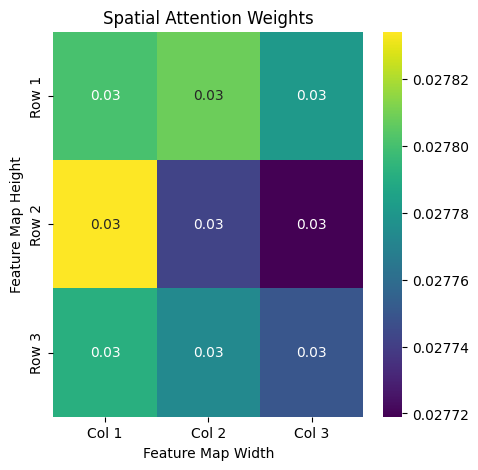

In [19]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# 示例注意力权重 (3,3)
attention_weights = attn[15]
print(attention_weights)

# 画热力图
plt.figure(figsize=(5, 5))
sns.heatmap(attention_weights.numpy(), annot=True, cmap="viridis", fmt=".2f",
            xticklabels=["Col 1", "Col 2", "Col 3"],
            yticklabels=["Row 1", "Row 2", "Row 3"])

plt.title("Spatial Attention Weights")
plt.xlabel("Feature Map Width")
plt.ylabel("Feature Map Height")
plt.show()


In [ ]:
from swin import SwinTransformer
import torch

model = SwinTransformer(patch_size=(8,3,3), 
                        depths=(2, 2, 2),
                        num_heads=(2,2,3),
                        window_size=(3,3,3)
                        ) # T, W, H 同时缩小
input_tensor = torch.randn(2, 1, 128, 9, 9)  # [B, C, T, H, W]

# 前向传播并获取初始Patch权重
output = model(input_tensor)
patch_weights = model.get_initial_patch_weights(input_tensor)  # [B, N]

print(patch_weights.shape)
# # 可视化关键Patch
# import matplotlib.pyplot as plt
# plt.imshow(patch_weights[0].view(3, 3, 3).sum(dim=0).detach().numpy())
# plt.title("Initial Patch Importance")
# plt.show()


In [ ]:
import numpy as np

# ✅ 创建存储注意力权重的列表
attn_weights = []

# ✅ 定义hook函数
def hook_fn(module, input, output):
    """
    将注意力权重保存到全局列表 attn_weights 中
    """
    # 获取注意力权重，维度为 (batch, num_heads, num_tokens, num_tokens)
    print(output.shape)
    attn_weights.append(output.detach().cpu())

# ✅ 注册 hook 到指定层
target_layer = 'layers.0.blocks.0.attn.softmax'
for name, module in model.named_modules():
    if name == target_layer:
        module.register_forward_hook(hook_fn)
        print(f"✅ Hook 注册在 {name}")

# ✅ 模拟输入数据 (batch_size, channels, depth, height, width)
input_tensor = torch.randn(2, 1, 128,9, 9)  # 3D EEG数据示例

# ✅ 推理模型
with torch.no_grad():
    output = model(input_tensor)

# ✅ 查看注意力权重
print("\n✅ 提取的注意力权重：")
for i, attn in enumerate(attn_weights):
    print(f"Layer {i + 1}: Shape {attn.shape}")

# ✅ 将注意力权重转换为 NumPy 格式，便于保存或可视化
attn_weights_np = [attn.numpy() for attn in attn_weights]

# # ✅ 保存注意力权重到本地
# np.save("attention_weights.npy", attn_weights_np)
# print("\n🎯 注意力权重已保存为 attention_weights.npy")

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ 加载保存的注意力权重
attn_weights_np  = attn1
# ✅ 将注意力权重转换为 NumPy 数组
batch_size = 2

# 🚀 确保维度正确
# B, H, N, _ = attn_weights_np.shape  # B=batch_size, H=window数, N=patch数
print(f"权重维度: {attn_weights_np.shape}")  # e.g., (12, 3, 27, 27)

# ✅ 特征图大小
T, W, H = 18, 3, 3  
w_t, w_h, w_w = 3, 3, 3  # 每个窗口大小

# ✅ 初始化完整特征图权重图
full_map = np.zeros((T, W, H))

# ✅ 将窗口内 patch 映射回特征图（不取均值）
num_windows = attn_weights_np.shape[0] / batch_size
windows_per_dim = [6,1,1]
window_weights = attn_weights_np[idx].mean(axis=1)  # 对头维度取均值

for idx in range(num_windows):
    # 计算窗口在特征图中的位置
    wt = (idx // windows_per_dim[0]) * w_t  # 时间维度起点
    wh = (idx % windows_per_dim[1]) * w_h   # 宽度维度起点

    # ✅ 取出窗口内的 patch 权重
    
    window_weights = window_weights.reshape(w_t, w_h, w_w)

    # ✅ 将窗口内的 patch 映射回特征图
    full_map[wt:wt+w_t, :, :] = window_weights  # 保持原始patch权重

# ✅ 可视化注意力权重热力图
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(full_map.mean(axis=1), cmap="viridis", cbar=True, annot=False)

ax.set_title("Attention Heatmap (No Patch Averaging)")
ax.set_xlabel("Width (W)")
ax.set_ylabel("Time (T)")
plt.show()

